In [0]:
from pyspark.sql.functions import col,  date_format, col,  lag, when,   mean, round, avg
from pyspark.sql.window import Window
import os

# configs
storage_account_name = os.environ.get('storage_account_name')
storage_account_key = os.environ.get("storage_account_key")
container_name = os.environ.get("container_name")

# timeseries technical indicators params
rsi_period = 14

symbols = [
    'BTCUSDT',
    'ETHUSDT',
    'BNBUSDT',
    'ETHBTC',
    'BNBETH',
    'BNBBTC',
]

def calculate_rsi(df, column, period):
    delta = col(column) - lag(column, 1).over(Window.orderBy('Close time'))
    gain = when(delta > 0, delta).otherwise(0)
    loss = when(delta < 0, -delta).otherwise(0)
    avg_gain = mean(gain).over(Window.partitionBy().orderBy('Close time').rowsBetween(-period, 0))
    avg_loss = mean(loss).over(Window.partitionBy().orderBy('Close time').rowsBetween(-period, 0))
    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    return df.withColumn("rsi", rsi)

In [0]:

symbols_and_idx_df = None
abfss_url = f"abfss://{container_name}@{storage_account_name}.dfs.core.windows.net/"
# calculate rsi of ema for each pair and join into
for symbol in symbols:
    blob_name = f"layers/silver/{symbol}.parquet"
    df = spark.read.parquet(f"{abfss_url}/{blob_name}")
    df = calculate_rsi(df, "Close", rsi_period)

    rsi = df.select("Close time", "rsi").withColumnRenamed("rsi", f"{symbol}")
    if symbols_and_idx_df is None:
        symbols_and_idx_df = df.select("Close Time")

    symbols_and_idx_df = symbols_and_idx_df.join(rsi, on="Close time")


symbols_and_idx_df = (
    symbols_and_idx_df.withColumn(
        "BTC", (col("BTCUSDT") + (100 - col("ETHBTC")) + (100 - col("BNBBTC"))) / 3
    )
    .withColumn("ETH", (col("ETHUSDT") + col("ETHBTC") + (100 - col("BNBETH"))) / 3)
    .withColumn("BNB", (col("BNBUSDT") + col("BNBETH") + col("BNBBTC")) / 3)
    .withColumn(
        "USDT",
        ((100 - col("BTCUSDT")) + (100 - col("ETHUSDT")) + (100 - col("BNBUSDT"))) / 3,
    )
)
symbols_and_idx_df = symbols_and_idx_df.dropna()

In [0]:
blob_name_to_write = f"layers/gold/symbols.parquet"

symbols_and_idx_df = symbols_and_idx_df.withColumn('Close time', date_format(col('Close time'), "yyyy-MM-dd HH:mm"))

for col_name, col_type in symbols_and_idx_df.dtypes:
    if col_type == 'double':
        symbols_and_idx_df = symbols_and_idx_df.withColumn(col_name, round(col_name, 2))

symbols_and_idx_df.write\
    .format("parquet")\
    .option('header', 'true')\
    .mode('overwrite')\
    .save(f'{abfss_url}/{blob_name_to_write}')

display(symbols_and_idx_df)

Close time,BTCUSDT,ETHUSDT,BNBUSDT,ETHBTC,BNBETH,BNBBTC,BTC,ETH,BNB,USDT
2023-12-23 23:59,28.66,83.86,0.0,97.31,11.32,47.95,27.8,89.95,19.76,62.49
2023-12-24 23:59,9.89,58.4,0.0,89.16,10.17,29.17,30.52,79.13,13.11,77.24
2023-12-25 23:59,41.44,60.39,24.0,70.43,19.7,23.33,49.23,70.37,22.34,58.05
2023-12-26 23:59,25.28,47.74,81.37,74.15,76.65,88.85,20.76,48.41,82.29,48.53
2023-12-27 23:59,44.08,70.36,88.69,85.47,79.13,92.28,22.11,58.9,86.7,32.29
2023-12-28 23:59,35.65,63.94,86.75,86.26,80.3,92.84,18.85,56.63,86.63,37.89
2023-12-29 23:59,32.12,57.1,76.8,80.17,76.6,86.33,21.87,53.56,79.91,44.66
2023-12-30 23:59,33.1,56.09,77.78,76.69,78.07,86.84,23.19,51.57,80.9,44.34
2023-12-31 23:59,34.93,54.83,73.0,71.95,73.9,80.22,27.59,50.96,75.71,45.75
2024-01-01 23:59,52.23,61.08,73.52,64.9,66.95,70.14,39.06,53.01,70.2,37.72


Databricks visualization. Run in Databricks to view.

/root/.ipykernel/854/command-1323500038332439-3494755487:21: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[0].set_xticklabels(labels=axes[0].get_xticklabels(), rotation=45)
/root/.ipykernel/854/command-1323500038332439-3494755487:27: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[1].set_xticklabels(labels=axes[1].get_xticklabels(), rotation=45)


[Text(19723.0, 0, '2024-01-01'),
 Text(19737.0, 0, '2024-01-15'),
 Text(19754.0, 0, '2024-02-01'),
 Text(19768.0, 0, '2024-02-15'),
 Text(19783.0, 0, '2024-03-01')]

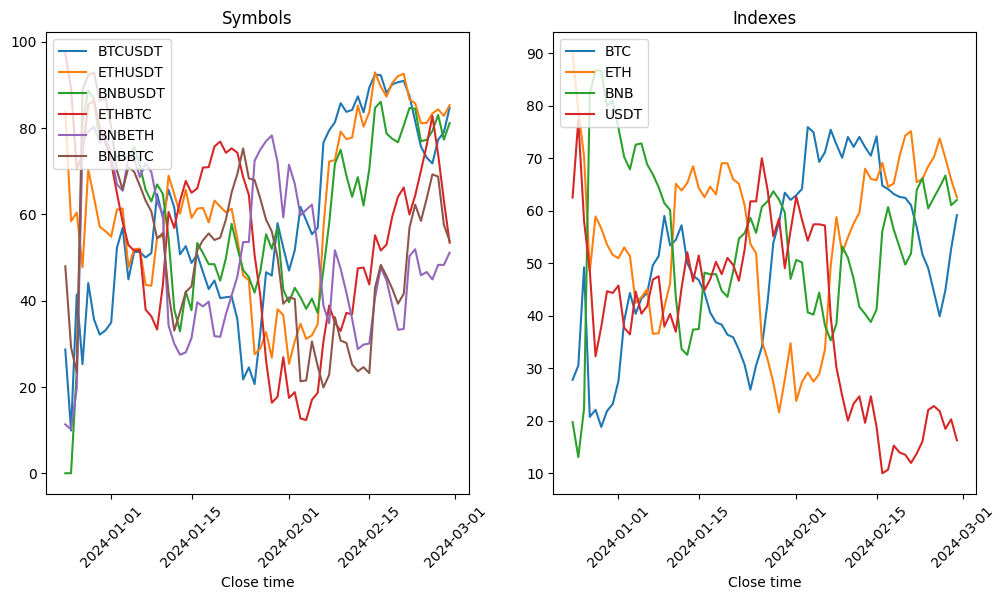

In [0]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Calculate correlation matrix for the sliced dataframe
pairs_df = symbols_and_idx_df.select(symbols + ['Close time']).toPandas()
pairs_df['Close time'] = pd.to_datetime(pairs_df['Close time'])
pairs_df.index = pairs_df['Close time']

idxs_df = symbols_and_idx_df.drop(*symbols).toPandas()
idxs_df['Close time'] = pd.to_datetime(idxs_df['Close time'])
idxs_df.index = pairs_df['Close time']

# Create subplots with 1 row and 2 columns
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Plot line graph with solid lines
sns.lineplot(data=pairs_df, dashes=False, ax=axes[0])
axes[0].legend(loc='upper left')
axes[0].set_title('Symbols')
axes[0].set_xticklabels(labels=axes[0].get_xticklabels(), rotation=45)

# Plot line graph with solid lines
sns.lineplot(data=idxs_df, dashes=False, ax=axes[1])
axes[1].legend(loc='upper left')
axes[1].set_title('Indexes')
axes[1].set_xticklabels(labels=axes[1].get_xticklabels(), rotation=45)

/root/.ipykernel/854/command-1323500038332440-153085432:5: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(pairs_df.reset_index(drop=True).corr(), annot=True, ax=axes[0])
/root/.ipykernel/854/command-1323500038332440-153085432:9: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(idxs_df.reset_index(drop=True).corr(), annot=True, ax=axes[1])


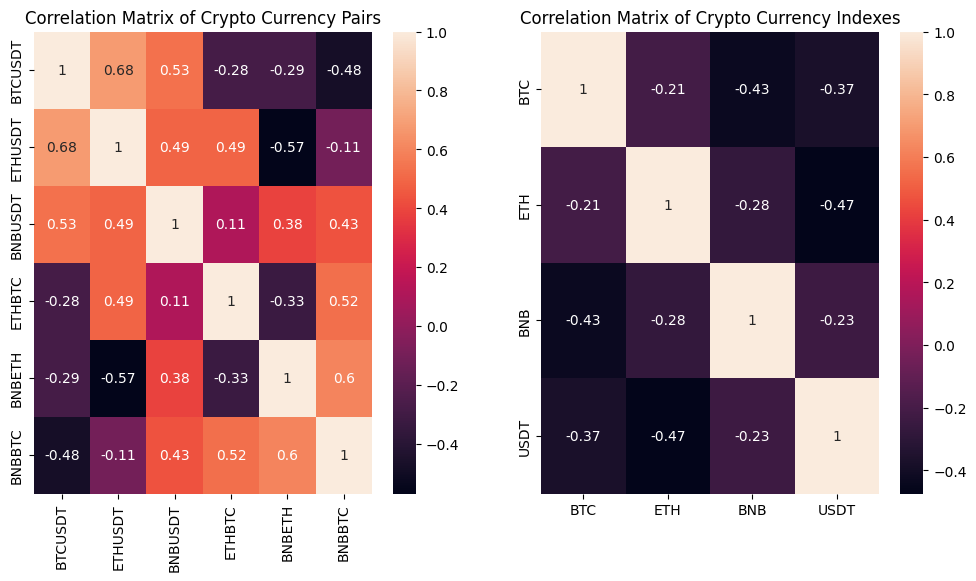

In [0]:
# Create subplots with 1 row and 2 columns
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Plot correlation matrix of the sliced dataframe as heatmap in the first subplot
sns.heatmap(pairs_df.reset_index(drop=True).corr(), annot=True, ax=axes[0])
axes[0].set_title('Correlation Matrix of Crypto Currency Pairs')

# Plot correlation matrix of the remaining columns as heatmap in the second subplot
sns.heatmap(idxs_df.reset_index(drop=True).corr(), annot=True, ax=axes[1])
axes[1].set_title('Correlation Matrix of Crypto Currency Indexes')

# Display the plots
plt.show()

/root/.ipykernel/854/command-1323500038332441-198351245:5: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = symbols_and_idx_df.toPandas().corr()


<Axes: >

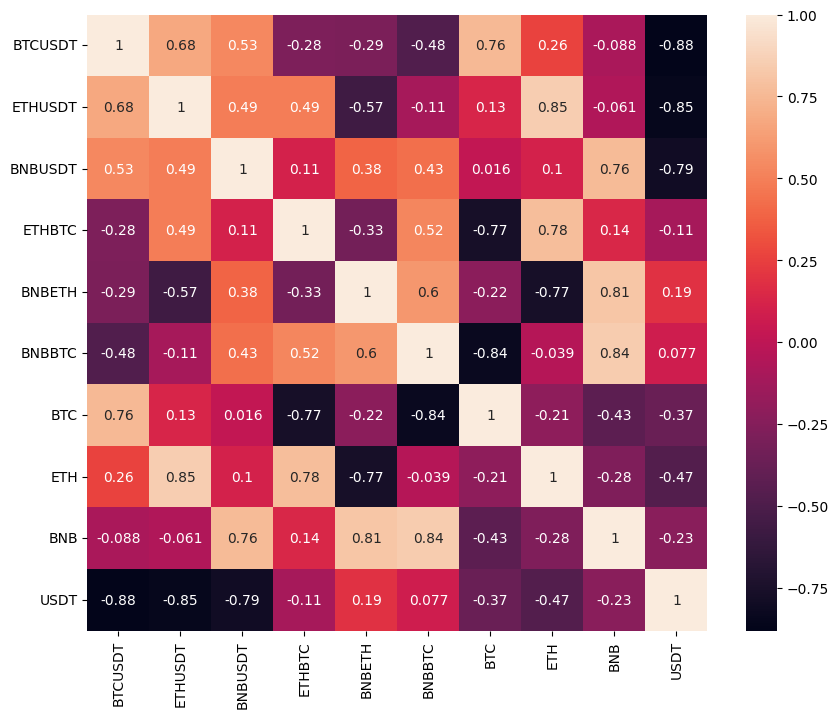

In [0]:
# Set size for the heatmap plot
fig, ax = plt.subplots(figsize=(10, 8))

# Create a correlation matrix from the symbols_and_idx_df dataframe
correlation_matrix = symbols_and_idx_df.toPandas().corr()

# Plot the correlation matrix as a heatmap
sns.heatmap(correlation_matrix, annot=True, ax=ax)